In [ ]:
# for colab
# ! wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1E9e4LmjUJxdSgfzfLJgXKOJqtUP6-xYs' -O data.zip
# ! unzip -qq data.zip

from google.colab import drive
drive.mount('/content/gdrive')
!unzip '/content/gdrive/My Drive/data.zip'

# Бейзлайн для распознавания автомобильных номеров. 

MADE with love :)

In [ ]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

import random
SEED = 40

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
torch.__version__, torch.cuda.is_available()

('1.5.0+cu101', True)

### Сейчас будет много вспомогательных функций, которые можно промотать

Чтобы было наглядно и не приходилось лезть в модули, чтобы посмотреть, какая функция что делает, оставил для наглядности пока что все в ноутбуке. Можно аккуратно перенести в модули :)

In [ ]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = my_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            # contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            _,contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [ ]:
DATA_PATH = './data/'
TRAIN_SIZE = 0.8
BATCH_SIZE = 2
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = 'detector.pt'
OCR_MODEL_PATH = 'ocr.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
# train_marks = all_marks[:test_start]
# val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def repl_it(s):
  eng = ['A',  'B',  'C',  'E',  'H',  'K',  'M',  'O',  'P',  'T',  'X',  'Y']
  rus = ['А',  'В',  'С',  'Е',  'Н',  'К',  'М',  'О',  'Р',  'Т',  'Х',  'У']
  s = s.upper()
  for i in range(12):
    s = s.replace(rus[i], eng[i])
  return s

for i in range(len(all_marks)):
  for j in range(len(all_marks[i]['nums'])):
    all_marks[i]['nums'][j]['text'] = repl_it(all_marks[i]['nums'][j]['text'])

train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

In [ ]:
# train_marks = all_marks[:4]
# train_marks[0:2]

# 1. Находим номера

### a) Модель для детекции

В задании есть данные о 4 точках, которые задают номер. Эти 4 точки - почти всегда не прямоугольник, а произвольный четырехугольник. Будем предсказывать:

- bounding box, который окружает точки (детекция)
- маску, заполненную тем, что внутри 4-х точек (сегментация)

Поэтому, возьмем maskrcnn. Будем обучать несколько последних солев. Этого с запасом хватает.

In [ ]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

### b) Датасет для детекции

In [ ]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='data/', 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='data/', 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

### c) Обучаем модель для детекции

In [ ]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
# model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.load_state_dict(torch.load(f"/content/gdrive/My Drive/madecvhw2/{DETECTOR_MODEL_PATH}"))
model.to(device);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


Валидироваться на чем-то нет смысла, ибо лосс перестает падать еще до того момента, как пройдет 1-я эпоха. Т.е. лосс на трейне вполне валидный, ибо модель видит данные в первый раз.

In [ ]:
# import math
# import torch
# from torch.optim.optimizer import Optimizer, required

# class RAdam(Optimizer):

#     def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
#         if not 0.0 <= lr:
#             raise ValueError("Invalid learning rate: {}".format(lr))
#         if not 0.0 <= eps:
#             raise ValueError("Invalid epsilon value: {}".format(eps))
#         if not 0.0 <= betas[0] < 1.0:
#             raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
#         if not 0.0 <= betas[1] < 1.0:
#             raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
#         self.degenerated_to_sgd = degenerated_to_sgd
#         if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
#             for param in params:
#                 if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
#                     param['buffer'] = [[None, None, None] for _ in range(10)]
#         defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
#         super(RAdam, self).__init__(params, defaults)

#     def __setstate__(self, state):
#         super(RAdam, self).__setstate__(state)

#     def step(self, closure=None):

#         loss = None
#         if closure is not None:
#             loss = closure()

#         for group in self.param_groups:

#             for p in group['params']:
#                 if p.grad is None:
#                     continue
#                 grad = p.grad.data.float()
#                 if grad.is_sparse:
#                     raise RuntimeError('RAdam does not support sparse gradients')

#                 p_data_fp32 = p.data.float()

#                 state = self.state[p]

#                 if len(state) == 0:
#                     state['step'] = 0
#                     state['exp_avg'] = torch.zeros_like(p_data_fp32)
#                     state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
#                 else:
#                     state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
#                     state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

#                 exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
#                 beta1, beta2 = group['betas']

#                 exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
#                 exp_avg.mul_(beta1).add_(1 - beta1, grad)

#                 state['step'] += 1
#                 buffered = group['buffer'][int(state['step'] % 10)]
#                 if state['step'] == buffered[0]:
#                     N_sma, step_size = buffered[1], buffered[2]
#                 else:
#                     buffered[0] = state['step']
#                     beta2_t = beta2 ** state['step']
#                     N_sma_max = 2 / (1 - beta2) - 1
#                     N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
#                     buffered[1] = N_sma

#                     # more conservative since it's an approximated value
#                     if N_sma >= 5:
#                         step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
#                     elif self.degenerated_to_sgd:
#                         step_size = 1.0 / (1 - beta1 ** state['step'])
#                     else:
#                         step_size = -1
#                     buffered[2] = step_size

#                 # more conservative since it's an approximated value
#                 if N_sma >= 5:
#                     if group['weight_decay'] != 0:
#                         p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
#                     denom = exp_avg_sq.sqrt().add_(group['eps'])
#                     p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
#                     p.data.copy_(p_data_fp32)
#                 elif step_size > 0:
#                     if group['weight_decay'] != 0:
#                         p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
#                     p_data_fp32.add_(-step_size * group['lr'], exp_avg)
#                     p.data.copy_(p_data_fp32)

#         return loss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# optimizer = RAdam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.notebook.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Loss: 0.1588262
Loss: 0.1558303
Loss: 0.1606567
Loss: 0.1719056
Loss: 0.1600385
Loss: 0.1471480
Loss: 0.1554971
Loss: 0.1438227
Loss: 0.1681047
Loss: 0.1522499
Loss: 0.1259744
Loss: 0.1475125
Loss: 0.1460462
Loss: 0.1635030
Loss: 0.1378555
Loss: 0.1448721
Loss: 0.1711039
Loss: 0.1514648
Loss: 0.1481718
Loss: 0.1438538
Loss: 0.1499773
Loss: 0.1386835
Loss: 0.1437307
Loss: 0.2093139
Loss: 0.1537023
Loss: 0.1680795
Loss: 0.1674921
Loss: 0.1608450
Loss: 0.1675744
Loss: 0.1569424
Loss: 0.1760189
Loss: 0.1869896
Epoch    32: reducing learning rate of group 0 to 1.5000e-04.
Loss: 0.1498590
Loss: 0.1422543
Loss: 0.1447282
Loss: 0.1267264
Loss: 0.1538945
Loss: 0.1719714
Loss: 0.1453892
Loss: 0.1603688
Loss: 0.1696125
Loss: 0.1642697
Loss: 0.1422179
Loss: 0.1577877
Loss: 0.1269871
Loss: 0.1478549
Loss: 0.1599675
Loss: 0.1509925
Loss: 0.1434713
Loss: 0.1282343
Loss: 0.1533466
Loss: 0.1479439
Loss: 0.1577739
Epoch    53: reducing learning rate of group 0 to 7.5000e-05.
Loss: 0.1366128
Loss: 0.1301

In [ ]:
torch.save(model.state_dict(), DETECTOR_MODEL_PATH)
# torch.save(model.state_dict(), f"/content/gdrive/My Drive/madecvhw2/{DETECTOR_MODEL_PATH}")

In [ ]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

In [ ]:
# test_images[0:6]
# './data/test/2249.jpg'

['./data/test/3067.bmp',
 './data/test/2693.jpg',
 './data/test/2599.jpg',
 './data/test/2267.jpg',
 './data/test/851.jpg',
 './data/test/2573.bmp']

Class: plate, Confidence: 0.9998927116394043
Bounding box:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


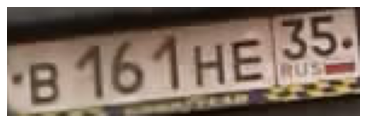

ValueError: ignored

In [ ]:
visualize_prediction_plate(np.random.choice(test_images), model, id_to_name={1: 'plate'}, thresh=0.95)

### d) Предсказываем bounding box-ы и маску. 

- Маску превращаем в 4-угольный полигон. Сохраняем предсказания в json
- Если маска не приближается 4-угольником (редко такое бывает, бинарный поиск по гиперпараметру не работает), то просто записываем координаты bounding box 

In [ ]:
THRESHOLD_SCORE = 0.93
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.notebook.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:      
            # В разных версиях opencv этот метод возвращает разное число параметров
            # Оставил для версии colab
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   

    
# with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
#     json.dump(preds, json_file, cls=npEncoder)

# with open('/content/gdrive/My Drive/test.json', 'w') as json_file:
#     json.dump(preds, json_file, cls=npEncoder)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


simplify_contour didnt coverege


In [ ]:
with open('test.json', 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)


with open('/content/gdrive/My Drive/madecvhw2/test.json', 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

In [ ]:
# А тут для трейна

In [ ]:
# THRESHOLD_SCORE = 0.95
# TRESHOLD_MASK = 0.05

# preds = []
# model.eval()

# train_images = glob.glob(os.path.join(DATA_PATH, 'train/*'))

# for file in tqdm.notebook.tqdm(train_images, position=0, leave=False):

#     try:

#         img = Image.open(file).convert('RGB')
#         img_tensor = my_transforms(img)
#         with torch.no_grad():
#             predictions = model([img_tensor.to(device)])
#         prediction = predictions[0]

#         pred = dict()
#         pred['file'] = file
#         pred['nums'] = []

#         for i in range(len(prediction['boxes'])):
#             x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
#             label = int(prediction['labels'][i].cpu())
#             score = float(prediction['scores'][i].cpu())
#             mask = prediction['masks'][i][0, :, :].cpu().numpy()

#             if score > THRESHOLD_SCORE:      
#                 # В разных версиях opencv этот метод возвращает разное число параметров
#                 # Оставил для версии colab
#                 contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#     #             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#                 approx = simplify_contour(contours[0], n_corners=4)
                
#                 if approx is None:
#                     x0, y0 = x_min, y_min
#                     x1, y1 = x_max, y_min
#                     x2, y2 = x_min, y_max
#                     x3, y3 = x_max, y_max
#                 else:
#                     x0, y0 = approx[0][0][0], approx[0][0][1]
#                     x1, y1 = approx[1][0][0], approx[1][0][1]
#                     x2, y2 = approx[2][0][0], approx[2][0][1]
#                     x3, y3 = approx[3][0][0], approx[3][0][1]
                    
#                 points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

#                 pred['nums'].append({
#                     'box': points,
#                     'bbox': [x_min, y_min, x_max, y_max],
#                 })

#     except:
#         continue

#     preds.append(pred)   

    
# with open(os.path.join(DATA_PATH, 'train_pred.json'), 'w') as json_file:
#     json.dump(preds, json_file, cls=npEncoder)

# with open('/content/gdrive/My Drive/madecvhw2/train_pred.json', 'w') as json_file:
#     json.dump(preds, json_file, cls=npEncoder)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


# 2. Распознаем номера

### a) Датасет для распознавания номеров

Из особенностей - на каждый номер мы генерируем bounding box + вырезаем по точкам и превращаем в прямоугольник наш 4-угольник по данным точкам. Т.е. 2 картинки на номер.

In [ ]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

0

### b) Модель для распознования текста номера

Взял RCNN из семинара

In [ ]:
# class FeatureExtractor(nn.Module):
    
#     def __init__(self, input_size=(64, 320), output_len=20):
#         super(FeatureExtractor, self).__init__()
        
#         h, w = input_size
#         resnet = getattr(models, 'resnet18')(pretrained=True)
#         self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
#         self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
#         self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
#         self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
#     def apply_projection(self, x):
#         """Use convolution to increase width of a features.
#         Accepts tensor of features (shaped B x C x H x W).
#         Returns new tensor of features (shaped B x C x H x W').
#         """
#         x = x.permute(0, 3, 2, 1).contiguous()
#         x = self.proj(x)
#         x = x.permute(0, 2, 3, 1).contiguous()
#         return x
   
#     def forward(self, x):
#         # Apply conv layers
#         features = self.cnn(x)
        
#         # Pool to make height == 1
#         features = self.pool(features)
        
#         # Apply projection to increase width
#         features = self.apply_projection(features)
        
#         return features
    
# class SequencePredictor(nn.Module):
    
#     def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
#         super(SequencePredictor, self).__init__()
        
#         self.num_classes = num_classes        
#         self.rnn = nn.GRU(input_size=input_size,
#                        hidden_size=hidden_size,
#                        num_layers=num_layers,
#                        dropout=dropout,
#                        bidirectional=bidirectional)
        
#         fc_in = hidden_size if not bidirectional else 2 * hidden_size
#         self.fc = nn.Linear(in_features=fc_in,
#                          out_features=num_classes)
    
#     def _init_hidden_(self, batch_size):
#         """Initialize new tensor of zeroes for RNN hidden state.
#         Accepts batch size.
#         Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
#         """
#         num_directions = 2 if self.rnn.bidirectional else 1
#         return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
#     def _prepare_features_(self, x):
#         """Change dimensions of x to fit RNN expected input.
#         Accepts tensor x shaped (B x (C=1) x H x W).
#         Returns new tensor shaped (W x B x H).
#         """
#         x = x.squeeze(1)
#         x = x.permute(2, 0, 1)
#         return x
    
#     def forward(self, x):
#         x = self._prepare_features_(x)
        
#         batch_size = x.size(1)
#         h_0 = self._init_hidden_(batch_size)
#         h_0 = h_0.to(x.device)
#         x, h = self.rnn(x, h_0)
        
#         x = self.fc(x)
#         return x
    
# class CRNN(nn.Module):
    
#     def __init__(
#         self, 
#         alphabet=alphabet,
#         cnn_input_size=(64, 320), 
#         cnn_output_len=20,
#         rnn_hidden_size=128, 
#         rnn_num_layers=2, 
#         rnn_dropout=0.3, 
#         rnn_bidirectional=False
#     ):
#         super(CRNN, self).__init__()
#         self.alphabet = alphabet
        
#         self.features_extractor = FeatureExtractor(
#             input_size=cnn_input_size, 
#             output_len=cnn_output_len
#         )
        
#         self.sequence_predictor = SequencePredictor(
#             input_size=self.features_extractor.num_output_features,
#             hidden_size=rnn_hidden_size, 
#             num_layers=rnn_num_layers,
#             num_classes=(len(alphabet) + 1), 
#             dropout=rnn_dropout,
#             bidirectional=rnn_bidirectional
#         )
    
#     def forward(self, x):
#         features = self.features_extractor(x)
#         sequence = self.sequence_predictor(features)
#         return sequence

In [ ]:
# Мой вариант crnn

class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        # x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        # self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        # embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(src)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=256, 
        rnn_num_layers=4, 
        rnn_dropout=0.3, 
        rnn_bidirectional=True
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )

        self.enc = Encoder(
            input_dim=self.features_extractor.num_output_features, 
            emb_dim=self.features_extractor.num_output_features,
            enc_hid_dim=rnn_hidden_size,
            dec_hid_dim=rnn_hidden_size,
            dropout=rnn_dropout
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        features = features.squeeze(1)
        features = features.permute(2, 0, 1)
        features, _ = self.enc(features)
        sequence = self.sequence_predictor(features)
        return sequence

In [ ]:
alphabet

'3X9TE8KOAB0Y7416P2H5MC'

### c) Обучаем модель для распознавания текста номера

In [ ]:
torch.cuda.empty_cache()
gc.collect()
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.load_state_dict(torch.load("/content/gdrive/My Drive/madecvhw2/ocr.pt"))
crnn.to(device);

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
# optimizer = RAdam(crnn.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [ ]:
# Здесь тоже оставил пока обучение без валидации. 
# Может, здесь и стоит валидировать. 
# Но опять же, 1-2 эпох хватает, а значит модель видит почти все данные 
# в первый раз и лосс на трейне вполне отражает реальность

crnn.train()
for epoch in range(2):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.notebook.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

Loss: 10.5262806
Loss: 8.9001208
Loss: 5.3547985
Loss: 3.2629997
Loss: 2.4851828
Loss: 2.0094744
Loss: 1.5979590
Loss: 1.2595441
Loss: 0.9733340
Loss: 0.7586519
Loss: 0.5826629
Loss: 0.4421439
Loss: 0.3335987
Loss: 0.2809521
Loss: 0.2358056
Loss: 0.1701256
Loss: 0.1463703
Loss: 0.1334004
Loss: 0.1201501
Loss: 0.1309429
Loss: 0.0809376
Loss: 0.0945268
Loss: 0.0970311
Loss: 0.0823917
Loss: 0.0668000
Loss: 0.0644443
Loss: 0.0691274
Loss: 0.0984842
Loss: 0.0676034
Loss: 0.0608373
Loss: 0.0654116
Loss: 0.0793122
Loss: 0.0705543
Loss: 0.0798759
Loss: 0.0705169
Loss: 0.0569056
Loss: 0.0522170
Loss: 0.0643960
Loss: 0.0759785
Loss: 0.0587016
Loss: 0.1105555
Loss: 0.0609709
Loss: 0.0592988
Loss: 0.0741307
Loss: 0.0390901
Loss: 0.0573333
Loss: 0.0559766
Loss: 0.0713928
Loss: 0.0400871
Loss: 0.0563331
Loss: 0.0776105
Loss: 0.0584325
Loss: 0.0726083
Loss: 0.0533881
Loss: 0.0512408
Loss: 0.0593845
Epoch    56: reducing learning rate of group 0 to 1.5000e-04.
Loss: 0.0558234
Loss: 0.0647098
Loss: 0.0

Loss: 0.0230898
Loss: 0.0243474
Loss: 0.0478162
Loss: 0.0427802
Loss: 0.0275404
Epoch   139: reducing learning rate of group 0 to 1.1719e-06.
Loss: 0.0385072
Loss: 0.0266876
Loss: 0.0216668
Loss: 0.0164722
Loss: 0.0300848
Loss: 0.0270338
Loss: 0.0383150
Loss: 0.0300256
Loss: 0.0262942
Loss: 0.0345583
Loss: 0.0211194
Loss: 0.0375545
Loss: 0.0218949
Loss: 0.0392640
Loss: 0.0219991
Epoch   154: reducing learning rate of group 0 to 5.8594e-07.
Loss: 0.0276830
Loss: 0.0294301
Loss: 0.0172483
Loss: 0.0440886
Loss: 0.0452582
Loss: 0.0227614
Loss: 0.0363210
Loss: 0.0298240
Loss: 0.0332100
Loss: 0.0188600
Loss: 0.0278895
Epoch   165: reducing learning rate of group 0 to 2.9297e-07.
Loss: 0.0246837
Loss: 0.0401910
Loss: 0.0219875
Loss: 0.0347904
Loss: 0.0370097
Loss: 0.0373281
Loss: 0.0356853
Loss: 0.0223231
Loss: 0.0341286
Loss: 0.0287275
Loss: 0.0393300
Epoch   176: reducing learning rate of group 0 to 1.4648e-07.
Loss: 0.0243963
Loss: 0.0409744
Loss: 0.0308264
Loss: 0.0397027
Loss: 0.0274049


In [ ]:
torch.save(crnn.state_dict(), OCR_MODEL_PATH)


torch.save(crnn.state_dict(), f"/content/gdrive/My Drive/madecvhw2/{OCR_MODEL_PATH}")

### d) Наконец, делаем предсказания

In [ ]:
# test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
test_marks = load_json('test.json')
# test_marks = load_json('/content/gdrive/My Drive/madecvhw2/test.json')
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.notebook.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"].replace('/kaggle/input/made-cv-hw2/','')
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission_pred.csv', index=False)

In [ ]:
df_submit

,file_name,plates_string
0,test/881.jpg,A961OO35
1,test/1151.bmp,B544HB35
2,test/588.jpg,M010OO42
3,test/2171.bmp,P209XP35 B158PA35
4,test/529.jpeg,H323HB125 O554YT777
...,...,...
3183,test/635.jpg,O520BE125
3184,test/216.bmp,E284EP35
3185,test/342.jpg,A042BH125
3186,test/1613.jpg,B494TT64 Y474YY64


In [ ]:
df_submit.to_csv('/content/gdrive/My Drive/madecvhw2/submission_pred.csv', index=False)

In [ ]:
# # Предсказания для трейна

# # test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
# train_marks = load_json('/content/gdrive/My Drive/madecvhw2/train_pred.json')
# # test_marks = load_json('/content/gdrive/My Drive/madecvhw2/test.json')
# crnn.eval()
# resizer = Resize()

# file_name_result = [] 
# plates_string_result = []

# for item in tqdm.notebook.tqdm(train_marks, leave=False, position=0):

#     img_path = item["file"].replace('/kaggle/input/made-cv-hw2/','')
#     img = cv2.imread(img_path)

#     results_to_sort = []
#     for box in item['nums']:
#         x_min, y_min, x_max, y_max = box['bbox']
#         img_bbox = resizer(img[y_min:y_max, x_min:x_max])
#         img_bbox = my_transforms(img_bbox)
#         img_bbox = img_bbox.unsqueeze(0)


#         points = np.clip(np.array(box['box']), 0, None)
#         img_polygon = resizer(four_point_transform(img, points))
#         img_polygon = my_transforms(img_polygon)
#         img_polygon = img_polygon.unsqueeze(0)

#         preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
#         preds_poly = crnn(img_polygon.to(device)).cpu().detach()

#         preds = preds_poly + preds_bbox
#         num_text = decode(preds, alphabet)[0]

#         results_to_sort.append((x_min, num_text))

#     results = sorted(results_to_sort, key=lambda x: x[0])
#     num_list = [x[1] for x in results]

#     plates_string = ' '.join(num_list)
#     file_name = img_path[img_path.find('train/'):]
#     # print (file_name)

#     file_name_result.append(file_name)
#     plates_string_result.append(plates_string)
    
# train_df = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
# train_df.to_csv('train_pred.csv', index=False)
# train_df.to_csv('/content/gdrive/My Drive/madecvhw2/train_pred.csv', index=False)

Как-то так :)

In [ ]:
# train_df = pd.read_csv('/content/gdrive/My Drive/madecvhw2/train_pred.csv')

In [ ]:
# train_df

,file_name,plates_string
0,train/25206.jpg,P753XO96
1,train/3305.jpg,K393XX116
2,train/1144.bmp,C963HO35
3,train/2059.bmp,E404AA35
4,train/6557.jpg,O130EY190
...,...,...
25627,train/11040.jpg,T021XE42
25628,train/8513.jpg,Y671TH86
25629,train/14204.jpg,E075XP42
25630,train/5836.bmp,B393HB35


## про дубли

In [ ]:
# cps = pd.read_csv('/content/gdrive/My Drive/madecvhw2/copies.csv')
# for row in cps.iterrows():
#   test_img, train_img = row[1]
#   im1 = cv2.imread('data/' + test_img.replace("\\",'/'), cv2.COLOR_BGR2RGB)
#   im2 = cv2.imread('data/' + train_img.replace("\\",'/'), cv2.COLOR_BGR2RGB)
#   plt.figure()
#   f, axarr = plt.subplots(1,2) 
#   plt.title(test_img + ' - ' + train_img)
#   axarr[0].imshow(im1)
#   axarr[1].imshow(im2)

# # Все дубли были найдены верно

In [ ]:
def repl_it(s):
  eng = ['A',  'B',  'C',  'E',  'H',  'K',  'M',  'O',  'P',  'T',  'X',  'Y']
  rus = ['А',  'В',  'С',  'Е',  'Н',  'К',  'М',  'О',  'Р',  'Т',  'Х',  'У']
  s = s.upper()
  for i in range(12):
    s = s.replace(rus[i], eng[i])
  return s

for i in range(len(all_marks)):
  for j in range(len(all_marks[i]['nums'])):
    all_marks[i]['nums'][j]['text'] = repl_it(all_marks[i]['nums'][j]['text'])

names = {}
for el in all_marks:
  dd = []
  for ele in el['nums']:
    dd.append(ele['text'])
  names[el['file']] = ' '.join(dd)

n = []
p = []
for k, v in names.items():
  n.append(k)
  p.append(v)
train_orig_df = pd.DataFrame({'file_name': n, 'plates_string_orig': p})

# merge_df = pd.merge(train_orig_df, train_df, on='file_name')
# merge_df = merge_df[merge_df.plates_string!='']
# merge_df = merge_df[merge_df.plates_string!=np.nan]

# merge_df['num1'] = merge_df.plates_string_orig.apply(lambda x: len(str(x).split(' ')))
# merge_df['num2'] = merge_df.plates_string.apply(lambda x: len(str(x).split(' ')))
# merge_df = merge_df[(merge_df.num1==1) & (merge_df.num2==1)]

# merge_df[merge_df.plates_string!=merge_df.plates_string_orig]

In [ ]:
train_orig_df

,file_name,plates_string_orig
0,train/0.jpg,B060BB125
1,train/1.jpg,M938OX116 H881OA116
2,train/2.jpg,A549XA163
3,train/3.jpg,O934MO190
4,train/4.bmp,T647TO35
...,...,...
25628,train/25628.jpg,T252TO150
25629,train/25629.bmp,B240PB35
25630,train/25630.jpg,K607AP199
25631,train/25631.bmp,T454HK35


In [ ]:
# merge_df = pd.merge(train_orig_df, train_df, on='file_name')
# merge_df = merge_df[merge_df.plates_string!='']
# merge_df = merge_df[merge_df.plates_string!=np.nan]

# merge_df['num1'] = merge_df.plates_string_orig.apply(lambda x: len(str(x).split(' ')))
# merge_df['num2'] = merge_df.plates_string.apply(lambda x: len(str(x).split(' ')))
# merge_df = merge_df[(merge_df.num1==1) & (merge_df.num2==1)]

# merge_df[merge_df.plates_string!=merge_df.plates_string_orig]

,file_name,plates_string_orig,plates_string,num1,num2
2,train/2.jpg,A549XA163,NaN,1,1
51,train/51.jpg,X9000XH90,X900XH90,1,1
62,train/62.jpg,X800OO98,X800OO97,1,1
173,train/173.jpg,M259KP75,M250KP75,1,1
190,train/190.jpg,B881BO133,B881BO112,1,1
...,...,...,...,...,...
25516,train/25516.bmp,A180XP35,A180XK36,1,1
25549,train/25549.jpg,K904XA86,X904XA86,1,1
25550,train/25550.bmp,B427KT35,A427KT35,1,1
25553,train/25553.bmp,AK143B35,AK743B35,1,1


In [ ]:
# merge_df.to_csv('/content/gdrive/My Drive/madecvhw2/merge_df.csv', index=False)

## Строим новую модель

In [ ]:
# torch.cuda.empty_cache()
# gc.collect()

31936

In [ ]:
# merge_df = pd.read_csv('/content/gdrive/My Drive/madecvhw2/merge_df.csv')

In [ ]:
# import torch.nn as nn
# import torch.optim as optim

# from torchtext.datasets import Multi30k
# from torchtext.data import Field, BucketIterator
# import torchtext

# import spacy
# import numpy as np

# import random
# import math
# import time

# SEED = 1234

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

In [ ]:
# # spacy_de = spacy.load('en')
# # spacy_en = spacy.load('en')
# token_to_idx = {index:char for index, char in enumerate('MBEPA318HC65094K27YTOX')} 
# idx_to_token = {char:index for index, char in enumerate('MBEPA318HC65094K27YTOX')}

# def tokenize_de(text):
#     """
#     Tokenizes German text from a string into a list of strings (tokens) and reverses it
#     """
#     return [idx_to_token[tok.upper()] for tok in text][::-1]

# def tokenize_en(text):
#     """
#     Tokenizes English text from a string into a list of strings (tokens)
#     """
#     return [idx_to_token[tok.upper()] for tok in text]

# SRC = Field(tokenize = tokenize_de, 
#             init_token = '<sos>', 
#             eos_token = '<eos>', 
#             lower = True)

# TRG = Field(tokenize = tokenize_en, 
#             init_token = '<sos>', 
#             eos_token = '<eos>', 
#             lower = True)


# # train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
# #                                                     fields = (SRC, TRG))

In [ ]:
# tokenize_de('A456TH56')
# # idx_to_token

[10, 11, 8, 19, 10, 11, 14, 4]

In [ ]:
# pos = torchtext.data.TabularDataset(
# path='/content/gdrive/My Drive/madecvhw2/merge_df.csv', format='csv',
# fields=[('name', torchtext.data.Field()),
#         ('src', torchtext.data.Field(tokenize=tokenize_de, 
#             init_token = '<sos>', 
#             eos_token = '<eos>',)),
# ('trg', torchtext.data.Field(tokenize=tokenize_en, 
#             init_token = '<sos>', 
#             eos_token = '<eos>',))])

KeyError: ignored

In [ ]:
# vars(pos.examples[100])

{'name': ['train/110.jpg'],
 'src': ['7', '2', 'P', 'H', '4', '0', '4', 'A'],
 'trg': ['A', '4', '0', '4', 'H', 'P', '2', '7']}

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# train_iter = torchtext.data.BucketIterator(
# dataset=pos, batch_size=32,
# sort_key=lambda x: data.interleave_keys(len(x.src), len(x.trg)))


In [ ]:
# b = next(iter(train_iter))

AttributeError: ignored

In [ ]:
# from __future__ import print_function

# from keras.models import Model
# from keras.layers import Input, LSTM, Dense
# import numpy as np

# batch_size = 64  # Batch size for training.
# epochs = 100  # Number of epochs to train for.
# latent_dim = 256  # Latent dimensionality of the encoding space.
# num_samples = 20000  # Number of samples to train on.
# # Path to the data txt file on disk.
# data_path = 'merge_df.txt'

# # Vectorize the data.
# input_texts = []
# target_texts = []
# input_characters = set()
# target_characters = set()
# with open(data_path, 'r', encoding='utf-8') as f:
#     lines = f.read().split('\n')
# for line in lines[: min(num_samples, len(lines) - 1)]:
#     input_text, target_text = line.split('\t')
#     target_text, input_text = ' '.join(list(input_text)), ' '.join(list(target_text))
#     # We use "tab" as the "start sequence" character
#     # for the targets, and "\n" as "end sequence" character.
#     target_text = '\t' + target_text + '\n'
#     input_texts.append(input_text)
#     target_texts.append(target_text)
#     for char in input_text:
#         if char not in input_characters:
#             input_characters.add(char)
#     for char in target_text:
#         if char not in target_characters:
#             target_characters.add(char)

# input_characters = sorted(list(input_characters))
# target_characters = sorted(list(target_characters))
# num_encoder_tokens = len(input_characters)
# num_decoder_tokens = len(target_characters)
# max_encoder_seq_length = max([len(txt) for txt in input_texts])
# max_decoder_seq_length = max([len(txt) for txt in target_texts])

# print('Number of samples:', len(input_texts))
# print('Number of unique input tokens:', num_encoder_tokens)
# print('Number of unique output tokens:', num_decoder_tokens)
# print('Max sequence length for inputs:', max_encoder_seq_length)
# print('Max sequence length for outputs:', max_decoder_seq_length)

# input_token_index = dict(
#     [(char, i) for i, char in enumerate(input_characters)])
# target_token_index = dict(
#     [(char, i) for i, char in enumerate(target_characters)])

# encoder_input_data = np.zeros(
#     (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
#     dtype='float32')
# decoder_input_data = np.zeros(
#     (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
#     dtype='float32')
# decoder_target_data = np.zeros(
#     (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
#     dtype='float32')

# for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
#     for t, char in enumerate(input_text):
#         encoder_input_data[i, t, input_token_index[char]] = 1.
#     encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
#     for t, char in enumerate(target_text):
#         # decoder_target_data is ahead of decoder_input_data by one timestep
#         decoder_input_data[i, t, target_token_index[char]] = 1.
#         if t > 0:
#             # decoder_target_data will be ahead by one timestep
#             # and will not include the start character.
#             decoder_target_data[i, t - 1, target_token_index[char]] = 1.
#     decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
#     decoder_target_data[i, t:, target_token_index[' ']] = 1.

Number of samples: 20000
Number of unique input tokens: 23
Number of unique output tokens: 25
Max sequence length for inputs: 17
Max sequence length for outputs: 19


In [ ]:
# # Define an input sequence and process it.
# encoder_inputs = Input(shape=(None, num_encoder_tokens))
# encoder = LSTM(latent_dim, return_state=True)
# encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# # We discard `encoder_outputs` and only keep the states.
# encoder_states = [state_h, state_c]

# # Set up the decoder, using `encoder_states` as initial state.
# decoder_inputs = Input(shape=(None, num_decoder_tokens))
# # We set up our decoder to return full output sequences,
# # and to return internal states as well. We don't use the
# # return states in the training model, but we will use them in inference.
# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
#                                      initial_state=encoder_states)
# decoder_dense = Dense(num_decoder_tokens, activation='softmax')
# decoder_outputs = decoder_dense(decoder_outputs)

# # Define the model that will turn
# # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# # Run training
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:
# model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_split=0.2)
# # Save model
# model.save('s2s.h5')

Train on 16000 samples, validate on 4000 samples
Epoch 1/100
16000/16000 [==============================] - 31s 2ms/step - loss: 1.2878 - accuracy: 0.5906 - val_loss: 1.0131 - val_accuracy: 0.6355
Epoch 2/100
16000/16000 [==============================] - 29s 2ms/step - loss: 0.9855 - accuracy: 0.6479 - val_loss: 0.9161 - val_accuracy: 0.6704
Epoch 3/100
16000/16000 [==============================] - 30s 2ms/step - loss: 0.8806 - accuracy: 0.6834 - val_loss: 0.8209 - val_accuracy: 0.7084
Epoch 4/100
16000/16000 [==============================] - 29s 2ms/step - loss: 0.7926 - accuracy: 0.7211 - val_loss: 0.7206 - val_accuracy: 0.7529
Epoch 5/100
16000/16000 [==============================] - 31s 2ms/step - loss: 0.6891 - accuracy: 0.7626 - val_loss: 0.6166 - val_accuracy: 0.7863
Epoch 6/100
16000/16000 [==============================] - 29s 2ms/step - loss: 0.5724 - accuracy: 0.8068 - val_loss: 0.4881 - val_accuracy: 0.8418
Epoch 7/100
16000/16000 [==============================] - 29s 

In [ ]:
# # Define sampling models
# encoder_model = Model(encoder_inputs, encoder_states)

# decoder_state_input_h = Input(shape=(latent_dim,))
# decoder_state_input_c = Input(shape=(latent_dim,))
# decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_outputs, state_h, state_c = decoder_lstm(
#     decoder_inputs, initial_state=decoder_states_inputs)
# decoder_states = [state_h, state_c]
# decoder_outputs = decoder_dense(decoder_outputs)
# decoder_model = Model(
#     [decoder_inputs] + decoder_states_inputs,
#     [decoder_outputs] + decoder_states)

# # Reverse-lookup token index to decode sequences back to
# # something readable.
# reverse_input_char_index = dict(
#     (i, char) for char, i in input_token_index.items())
# reverse_target_char_index = dict(
#     (i, char) for char, i in target_token_index.items())


# def decode_sequence(input_seq):
#     # Encode the input as state vectors.
#     states_value = encoder_model.predict(input_seq)

#     # Generate empty target sequence of length 1.
#     target_seq = np.zeros((1, 1, num_decoder_tokens))
#     # Populate the first character of target sequence with the start character.
#     target_seq[0, 0, target_token_index['\t']] = 1.

#     # Sampling loop for a batch of sequences
#     # (to simplify, here we assume a batch of size 1).
#     stop_condition = False
#     decoded_sentence = ''
#     while not stop_condition:
#         output_tokens, h, c = decoder_model.predict(
#             [target_seq] + states_value)

#         # Sample a token
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_char = reverse_target_char_index[sampled_token_index]
#         decoded_sentence += sampled_char

#         # Exit condition: either hit max length
#         # or find stop character.
#         if (sampled_char == '\n' or
#            len(decoded_sentence) > max_decoder_seq_length):
#             stop_condition = True

#         # Update the target sequence (of length 1).
#         target_seq = np.zeros((1, 1, num_decoder_tokens))
#         target_seq[0, 0, sampled_token_index] = 1.

#         # Update states
#         states_value = [h, c]

#     return decoded_sentence

In [ ]:
# for seq_index in range(100):
#     # Take one sequence (part of the training set)
#     # for trying out decoding.
#     input_seq = encoder_input_data[seq_index: seq_index + 1]
#     decoded_sentence = decode_sequence(input_seq)
#     # print('-')
#     # print('Input sentence:', input_texts[seq_index])
#     # print('Decoded sentence:', decoded_sentence)
#     if input_texts[seq_index].replace(' ', '') != decoded_sentence.replace(' ', '').replace('\n',''):
#       print('Inp:', input_texts[seq_index].replace(' ', ''))
#       print('Dec:', decoded_sentence.replace(' ', ''))
#       print (seq_index)

Inp: X900XH90
Dec: X9000XH9

44
Inp: X800OO97
Dec: X800OO98

54


In [ ]:
# input_texts[seq_index].replace(' ', ''), decoded_sentence.replace(' ', '')

('T649PC35', 'T649PC35\n')

In [ ]:
# data_path = 'subm.txt'

# # Vectorize the data.
# input_texts = []
# # target_texts = []
# input_characters = set()
# # target_characters = set()
# with open(data_path, 'r', encoding='utf-8') as f:
#     lines = f.read().split('\n')
# for line in lines[: min(num_samples, len(lines) - 1)]:
#     input_text, target_text = line.split('\t')
#     input_text, target_text = ' '.join(list(input_text)), ' '.join(list(target_text))
#     # We use "tab" as the "start sequence" character
#     # for the targets, and "\n" as "end sequence" character.
#     # target_text = '\t' + target_text + '\n'
#     input_texts.append(input_text)
#     # target_texts.append(target_text)
#     # for char in input_text:
#     #     if char not in input_characters:
#     #         input_characters.add(char)
#     # for char in target_text:
#     #     if char not in target_characters:
#     #         target_characters.add(char)

# # input_characters = sorted(list(input_characters))
# # target_characters = sorted(list(target_characters))
# # num_encoder_tokens = len(input_characters)
# # num_decoder_tokens = len(target_characters)
# # max_encoder_seq_length = max([len(txt) for txt in input_texts])
# # max_decoder_seq_length = max([len(txt) for txt in target_texts])

# # print('Number of samples:', len(input_texts))
# # print('Number of unique input tokens:', num_encoder_tokens)
# # print('Number of unique output tokens:', num_decoder_tokens)
# # print('Max sequence length for inputs:', max_encoder_seq_length)
# # print('Max sequence length for outputs:', max_decoder_seq_length)

# # input_token_index = dict(
# #     [(char, i) for i, char in enumerate(input_characters)])
# # target_token_index = dict(
# #     [(char, i) for i, char in enumerate(target_characters)])

# encoder_input_data = np.zeros(
#     (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
#     dtype='float32')
# # decoder_input_data = np.zeros(
# #     (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
# #     dtype='float32')
# # decoder_target_data = np.zeros(
# #     (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
# #     dtype='float32')

# for i, input_text in enumerate(input_texts):
#     for t, char in enumerate(input_text):
#         encoder_input_data[i, t, input_token_index[char]] = 1.
#     encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
#     # for t, char in enumerate(target_text):
#     #     # decoder_target_data is ahead of decoder_input_data by one timestep
#     #     decoder_input_data[i, t, target_token_index[char]] = 1.
#     #     if t > 0:
#     #         # decoder_target_data will be ahead by one timestep
#     #         # and will not include the start character.
#     #         decoder_target_data[i, t - 1, target_token_index[char]] = 1.
#     # decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
#     # decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [ ]:
# inp = []
# out = []
# for seq_index in tqdm.notebook.tqdm(range(len(input_texts))):
#     # Take one sequence (part of the training set)
#     # for trying out decoding.
#     input_seq = encoder_input_data[seq_index: seq_index + 1]
#     decoded_sentence = decode_sequence(input_seq)
#     # print('-')
#     # print('Input sentence:', input_texts[seq_index])
#     # print('Decoded sentence:', decoded_sentence)
#     inp.append(input_texts[seq_index].replace(' ', ''))
#     out.append(decoded_sentence.replace(' ', '').replace('\n', ''))
#     # if seq_index == 4:
#     #   break

In [ ]:
# help_sub = pd.DataFrame({'inp': inp, 'out': out})
# help_sub

,inp,out
0,B558TA35,B558TA35
1,O300AT96,O300AT96
2,C863MP53,C863MP53
3,M858OA58,M858OA58
4,M505EC71,M505EC71
...,...,...
2928,C606KY77,C606KY77
2929,P104HT16,P104HT16
2930,A185OA43,A185OA43
2931,O281PY54,O281PY54


In [ ]:
# help_sub.to_csv('help_sub.csv', index=False)

In [ ]:
cps = pd.read_csv('/content/gdrive/My Drive/madecvhw2/copies.csv')
cps

,test,train
0,test\1021.bmp,train\24646.bmp
1,test\1023.bmp,train\21968.bmp
2,test\1047.bmp,train\5782.bmp
3,test\1060.bmp,train\13592.bmp
4,test\1061.jpg,train\23117.jpg
...,...,...
220,test\951.bmp,train\22210.bmp
221,test\951.bmp,train\4968.bmp
222,test\969.bmp,train\10798.bmp
223,test\979.bmp,train\11759.bmp


In [ ]:
df_sub = df_submit.copy()

for row in cps.iterrows():
  test_im, train_im = row[1][0].replace("\\",'/'), row[1][1].replace("\\",'/')
  true_num = train_orig_df[train_orig_df['file_name']==train_im]['plates_string_orig'].values[0]
  pred_num = df_sub[df_sub['file_name']==test_im]['plates_string'].values[0]
  if true_num != pred_num:
    print (test_im, train_im, true_num, pred_num)
    df_sub.loc[df_sub['file_name']==test_im, ['plates_string']] = true_num
  else:
    continue

test/1023.bmp train/21968.bmp B091YY35 B091YM35
test/1061.jpg train/23117.jpg E988MT44 M440BO199 M440BO199 E988MT44
test/1177.jpg train/7147.jpg H940TX11 H238YY96 H940TX11 H238YY96 H777HH43
test/1212.jpg train/2634.jpg P702PP199 O702OO199 O731OO77
test/1382.bmp train/24431.bmp P325PC38 O325PC38
test/1382.bmp train/24851.bmp O325PC38 P325PC38
test/1603.bmp train/11269.bmp B878EH35 B875KX35 B875KK35 B878EH35
test/1723.bmp train/16578.bmp T367XY35 Y028KP35 T267XY35 Y028KP35
test/1723.bmp train/19803.bmp T267XY35 T367XY35 Y028KP35
test/1839.bmp train/9412.bmp H646XT190 H646XT199
test/1920.bmp train/1351.bmp AM125E35 A0125E35
test/2093.bmp train/7932.bmp A362HP97 A362MP97
test/2171.bmp train/8684.bmp P209XP35 P209XP35 B158PA35
test/2212.bmp train/16718.bmp B191EY35 T616XY35 B716PC35 B191EY35 B116KM35
test/2212.bmp train/19626.bmp T616XY35 B716PC35 B191EY35 B191EY35
test/2395.bmp train/22249.bmp B222AT35 B822AT35
test/251.bmp train/20841.bmp X234YY35 X234YY59
test/251.bmp train/23138.bmp X23

In [ ]:
df_sub.to_csv('submission_pred.csv', index=False)